+ Saved wafer map: /nfshome/natpenn/Desktop/wafer_map_CROCv2.pdf


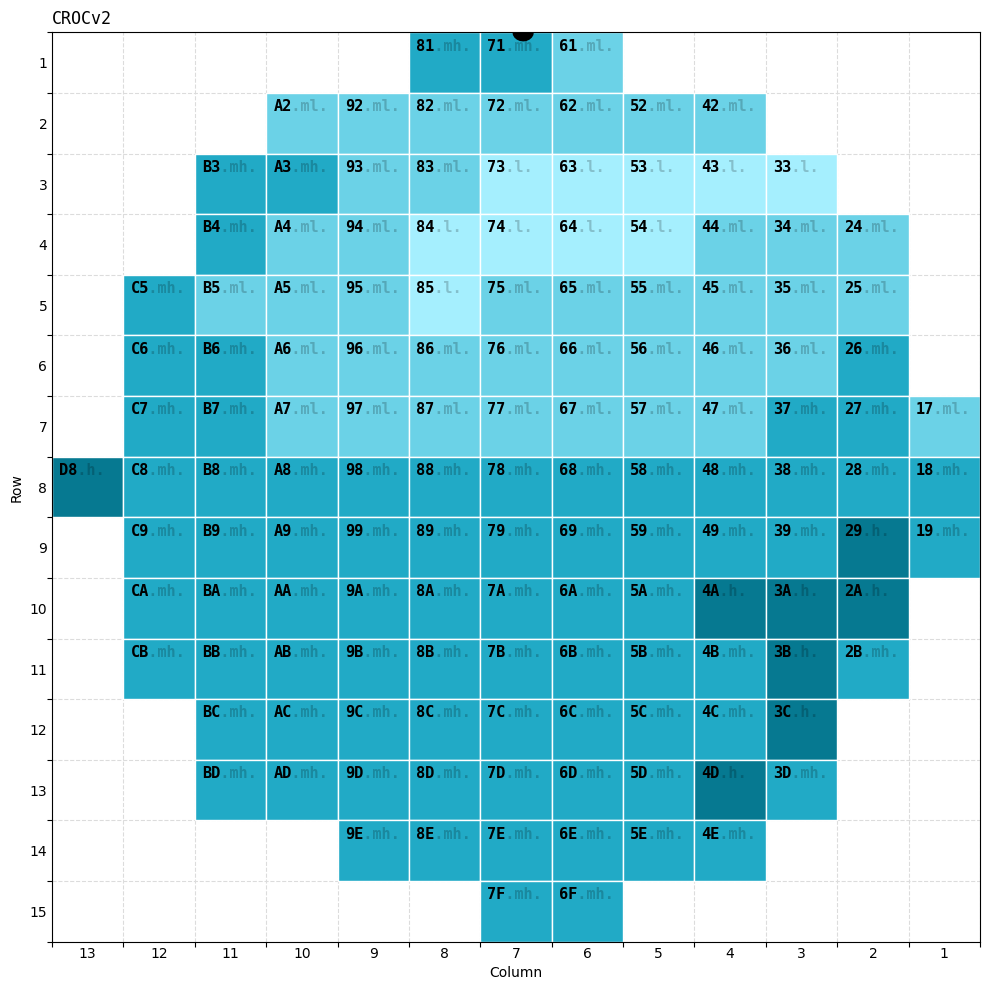

In [89]:
#Topography map draft
#TODO: 
    #Do something with Asymmetry?


#Original wafermap code:

#!/usr/bin/env python3
#pylint: disable=E1101
"""
Utility module for drawing wafer maps using the `matplotlib` package.

Wafer maps summarize the results of the tests performed on each chip on the
wafer. Different colors signal whether the test results are valid or not.
"""

import os
import numpy as np
import re

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.ticker as mticker

#from wlt.config import main_config
from wlt.duts.wafers import WAFER_MAPS


class TopographyMap:
	"""Helper class to visualise a wafer map with data and status of each chip"""

	#STATUS_COLORS = {-1: '#0000FF', 0: '#06d6a0', 1: '#ffd166', 2: '#ef476f'}
	#STATUS_NAMES =  {-1: 'b',       0: 'g',       1: 'y',       2: 'r'}
	STATUS_COLORS = {-1: '#A5EFFE', 0: '#6BD2E7', 1: '#21AAC6', 2: '#067991'}
	STATUS_NAMES =  {-1: 'l',       0: 'ml',       1: 'mh',       2: 'h'}
	DEFAULT_COLOR = '#808080'

	def __init__(self, chip_type, title=None, status_colors=None, size=(10,10), transform=None):

		if chip_type not in WAFER_MAPS:
			raise ValueError(f"Unsupported chip type: {chip_type}")

		# Assigning the chip type
		self.chip_type = chip_type
		self.map = WAFER_MAPS[chip_type]['map']
		self.notch = WAFER_MAPS[chip_type]['notch_position']
		self.axis_orientation = WAFER_MAPS[chip_type]['axis_orientation']
		# Applying the axis transformation
		if transform is not None:
			self.axis_orientation = tuple(np.array(self.axis_orientation) * np.array(transform))

		# Setting the styles
		self.status_colors = status_colors if status_colors is not None else self.STATUS_COLORS

		# Setting up the Matplotlib figure
		self.figsize = size
		self.fig = plt.figure(figsize=self.figsize, clear=True)
		self.ax = self.fig.add_subplot()

		# Setting up the graphics placeholders for faster redrawing
		self.chip_status = {}
		self.chip_rect = {}
		self.chip_title = {}
		self.chip_title_bkg = {}
		self.chip_text = {}
		self.chip_subtext = {}
		self.generate_grid()

		# Adding the IGNORED label
		self.test_ignored = False
		self.label_ignored = self.ax.text(1.0, 1.005, '',
		                                  fontsize='large', transform=self.ax.transAxes,
		                                  horizontalalignment='right',
		                                  verticalalignment='bottom',
		                                  family='monospace', weight='bold',
		                                  color='red')
		# Adding the count labels
		self.labels_counts = {}
		for status, color in self.STATUS_COLORS.items():
			self.labels_counts[status] = self.ax.text(0.995, 0.995, '', fontsize='x-large',
			                                          transform=self.ax.transAxes,
			                                          horizontalalignment='right',
			                                          verticalalignment='top',
			                                          family='monospace', weight='bold',
			                                          color=color)
		# Adding the title
		self.ax.set_title(' ', loc='left', family='monospace', fontsize='large')
		self.txt_title = self.ax.text(0.0, 1.005, ' ', fontsize='large',
		                              family='monospace', transform=self.ax.transAxes,
		                              horizontalalignment='left', verticalalignment='bottom')
		self.txt_title_bold = self.ax.text(0.0, 1.005, ' ', weight='bold', fontsize='large',
		                                   family='monospace', transform=self.ax.transAxes,
		                                   horizontalalignment='left', verticalalignment='bottom')
		self.set_title(title)


	def set_title(self, title, title_bold=None):
		"""Sets the title of the wafer map"""

		self.title = title
		self.txt_title.set_text(title)
		if title_bold:
			self.txt_title_bold.set_text(title_bold)


	def generate_grid(self):
		"""Generates the grid of the wafer"""

		# Calculating the numbers of rows and columns to draw
		cols, rows = zip(*self.map)
		bins_x = np.array(range(min(cols), max(cols)+1))
		bins_y = np.array(range(min(rows), max(rows)+1))
		# Setting the axis ranges and ticks
		self.ax.set_ylim(min(bins_y), max(bins_y)+1)
		self.ax.set_xlim(min(bins_x), max(bins_x)+1)
		self.ax.set_axisbelow(True)
		# Setting the axis orientations
		padding = [0.1, 0.9]
		if self.axis_orientation[0] < 0:
			self.ax.xaxis.set_inverted(True)
			padding[0] = 0.9
		if self.axis_orientation[1] < 0:
			self.ax.yaxis.set_inverted(True)
			padding[1] = 0.1
		# Centering the bin labels
		for ax, label in zip((self.ax.xaxis, self.ax.yaxis), ('Column', 'Row')):
			ax.set_major_locator(mticker.MultipleLocator(1))
			ax.set_minor_locator(mticker.MultipleLocator(0.5))
			ax.set_major_formatter(mticker.NullFormatter())
			ax.set_minor_formatter(lambda x, p: f'{int(x)}')
			ax.set_tick_params(which='minor', length=0)
			ax.set_label_text(label)

		# Drawing the grid
		self.ax.grid(True, color='gainsboro', linestyle='--', zorder=0)

		# Reducing the margins
		self.fig.subplots_adjust(left=0.12, right=0.94, top=0.9, bottom=0.1)

		# Drawing the chip rectangles
		for chip in self.map:
			col, row = chip
			rect = mpatches.Rectangle((col, row), 1.0, 1.0,
			                          edgecolor='white')
			self.chip_rect[chip] = self.ax.add_patch(rect)
			# Chip ID with the status letter (background layer for text search)
			self.chip_title_bkg[chip] = self.ax.text(col+padding[0], row+padding[1], '',
			                                         fontsize=1.1*self.figsize[0],
			                                         horizontalalignment='left',
			                                         verticalalignment='top', family='monospace',
			                                         color='black', weight='bold', alpha=0.2)
			# Chip ID
			self.chip_title[chip] = self.ax.text(col+padding[0], row+padding[1],
			                                     f'{col:X}{row:X}',
			                                     fontsize=1.1*self.figsize[0],
			                                     horizontalalignment='left',
			                                     verticalalignment='top', family='monospace',
			                                     color='black', weight='bold')
			# Chip value
			self.chip_text[chip] = self.ax.text(col+padding[0], row+padding[1], '',
			                                    fontsize='small',
			                                    horizontalalignment='left',
			                                    verticalalignment='top',
			                                    family='monospace', color='black', alpha=0.7)
			# Chip sub-string
			self.chip_subtext[chip] = self.ax.text(col+padding[0], row+padding[1], '',
			                                       fontsize='small',
			                                       horizontalalignment='left',
			                                       verticalalignment='top',
			                                       family='monospace', color='white', alpha=0.7)

		# Drawing the notch, if defined
		if self.notch is not None:
			notch = mpatches.CirclePolygon(self.notch, 0.15,
			                               facecolor='black', fill=True)
			self.ax.add_patch(notch)


	def set_chip(self, chip_id, status, value=None, str_format='{0}', add_status_label=True):
		"""Setting the status and value of the chip"""

		if chip_id not in self.map:
			raise ValueError(f'Inconsistent chip ID: {chip_id}')
		self.chip_status[chip_id] = status
		chip_rect = self.chip_rect[chip_id]
		# Styling the chip
		chip_rect.set_fill(True)
		chip_rect.set_hatch(None)
		if status in self.STATUS_COLORS:
			chip_rect.set_facecolor(self.STATUS_COLORS[status])
			if value is not None:
				chip_str = str_format.format(value)
				self.chip_text[chip_id].set_text('\n\n'+chip_str)
		else:
			chip_rect.set_facecolor(self.DEFAULT_COLOR)
			self.chip_text[chip_id].set_text(None)
		# Updating the background title
		if add_status_label:
			col, row = chip_id
			chip_title = f'{col:X}{row:X}.{self.STATUS_NAMES[status]:s}'
			# Adding a dot if the test is not ignored
			if not self.test_ignored:
				chip_title += '.'
			self.chip_title_bkg[chip_id].set_text(chip_title)


	def set_chip_subtext(self, chip_id, text=None):
		"""Setting an additional text string"""

		if text is None:
			return
		if chip_id not in self.map:
			raise ValueError(f'Inconsistent chip ID: {chip_id}')
		self.chip_subtext[chip_id].set_text('\n\n\n'+text)


	def set_ignored(self, ignored=False):
		"""Sets the label saying whether this result is ignored in the chip acceptance"""
		self.test_ignored = ignored
		if ignored:
			self.label_ignored.set_text('IGNORED')
		else:
			self.label_ignored.set_text(None)



	def update_chip_counts(self):
		"""Draws the counts of chips with each status"""

		statuses = list(self.chip_status.values())
		for status, label in self.labels_counts.items():
			if len(statuses) > 0:
				count = statuses.count(status)
				line_offset = status
				if status < 0:
					line_offset = max(self.labels_counts.keys()) + abs(status)
				txt = ['\n'] * line_offset
				txt = ''.join(txt) + str(count)
				label.set_text(txt)
			else:
				label.set_text(None)


	def reset_chips(self):
		"""Resets the style of each chip in the map"""

		for chip, chip_rect in self.chip_rect.items():
			chip_rect.set_fill(True)
			chip_rect.set_hatch('///')
			chip_rect.set_facecolor(self.DEFAULT_COLOR)
			self.chip_text[chip].set_text(None)
			self.chip_title_bkg[chip].set_text(None)
		self.chip_status = {}
		self.set_ignored(False)


	def save(self, path):
		"""Saves the figure to a file"""

		out_dir = os.path.split(path)[0]
		if not os.path.isdir(out_dir):
			os.makedirs(out_dir, exist_ok=True)
		self.fig.tight_layout()
		self.fig.savefig(path)


        
        
        
#Finding and setting chip statuses        

#Open file
with open('/nfshome/natpenn/Desktop/wafer_NC0W14-05A4/20240607_150356/wafer_NC0W14-05A4_20240607_150356.log', 'r') as file:
    log_content = file.readlines()

#Set up patterns
waferpattern = r'Wafer: (\w\w\w\w)'
waferid = ""
chippattern = r'(\d{4}-\d{2}-\d{2} \d{2}:\d{2}:\d{2},\d{3}) \| WaferTester \((\S\S\S\S)\)   \| INFO     \| Testing chip \S\S\S\S\S\S\S\S\S\S\S\S(\S\S)'
contactpattern = r'(\d{4}-\d{2}-\d{2} \d{2}:\d{2}:\d{2},\d{3}) \| WaferTester \((\S\S\S\S)\)   \| INFO     \| Found contact height: (.*)'
chipids = []
contactheight = []
for line in log_content:
    chipmatch = re.search(chippattern, line)
    contactmatch = re.search(contactpattern, line)
    wafermatch = re.search(waferpattern, line)
    if chipmatch:
        chipid = str(chipmatch.group(3))
        chipids.append(chipid)
    elif contactmatch:
        contactheight.append(contactmatch.group(3))
    elif wafermatch:
        waferid = str(wafermatch.group(1))
                             
#Organize data
contactheight = [int(i[:5]) for i in contactheight]

#Format chips (e.g. A9 is (10,9))
chip_coords = [f'({s[0]},{s[1]})' for s in chipids]
letter_to_number = {
    'A': '10', 'B': '11', 'C': '12', 'D': '13', 'E': '14', 'F': '15'}
def multiple_substitutions(s):
    pattern = re.compile('|'.join(map(re.escape, letter_to_number.keys())))
    return pattern.sub(lambda match: letter_to_number[match.group(0)], s)
chiplocations = [multiple_substitutions(s) for s in chip_coords]

#sort chips into statuses
low = []
medlow = []
medhigh = []
high = []
for i in range(len(contactheight)):
    value_height = contactheight[i]
    value_chip = chiplocations[i]
    if value_height < 16025:
        low.append(value_chip)
    elif value_height < 16030 and value_height >= 16025:
        medlow.append(value_chip)
    elif value_height < 16035 and value_height >= 16030:
        medhigh.append(value_chip)
    elif value_height >= 16035:
        high.append(value_chip)

#format lists
low = [eval(item) for item in low]
medlow = [eval(item) for item in medlow]
medhigh = [eval(item) for item in medhigh]
high = [eval(item) for item in high]

#set statuses
chip_statuses = {
		(-1, ''): low,    
		( 0, ''): medlow,                
		( 1, ''): medhigh,  
		( 2, ''): high,               
    }

#Create map
ch_type ='CROCv2'
wafer_map = TopographyMap(chip_type=ch_type, title=ch_type)
for (chip_status, chip_value), chips in chip_statuses.items():
    for ch_id in chips:
        wafer_map.set_chip(ch_id, chip_status, chip_value)

dir = '/nfshome/natpenn/Desktop'

out_path = os.path.join(dir, f'wafer_map_{ch_type}.pdf')

wafer_map.save(out_path)
print(f'+ Saved wafer map: {out_path}')


In [54]:
coordinates_list = ['(7,3)', '(6,3)', '(5,3)', '(4,3)', '(3,3)', '(5,4)', '(6,4)', '(7,4)', '(8,4)', '(8,5)']

print(', '.join(coordinates_list))

(7,3), (6,3), (5,3), (4,3), (3,3), (5,4), (6,4), (7,4), (8,4), (8,5)
